#Exercise from 2/9/2021 written exam

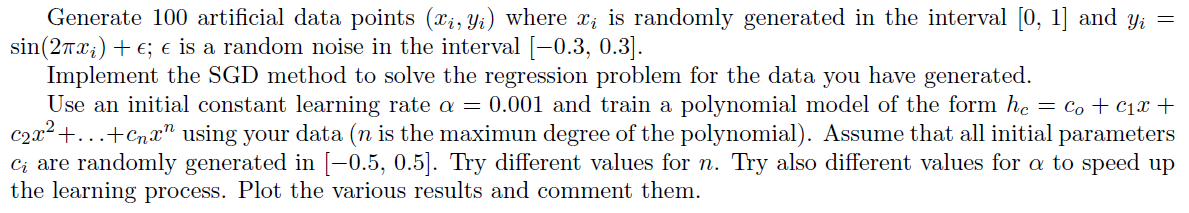

Traced<ShapedArray(float32[100])>with<DynamicJaxprTrace(level=0/1)>


  0%|          | 0/10000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fb3c9807270>, invars=(Traced<ShapedArray(float32[]):JaxprTrace(level=1/1)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/1)>), outvars=[<weakref at 0x7fb3c98043b0; to 'JaxprTracer' at 0x7fb3c9804680>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(fn)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = add a b in (c,) }}, source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fb3c980d370>))


TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/jax.ops.html

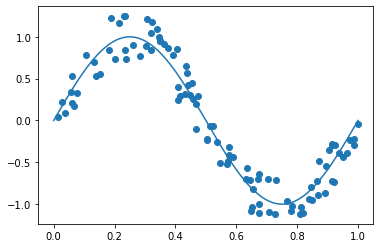

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import jax.numpy as jnp
import jax
from tqdm.notebook import tqdm

x = np.random.rand(100)

func = lambda x: np.sin(2 * np.pi * x)
error = 0.3

y_ex = func(x)
y = y_ex + (2 * np.random.rand(100) - 1) * error

x_fine = np.linspace(0,1,1000)
plt.plot(x_fine, func(x_fine))
plt.scatter(x,y)

def model(x,params):
    #print(sum([c * x ** i for (i, c) in enumerate(params)]))
    return sum([c * x ** i for (i, c) in enumerate(params)])

def loss(x, y, params):
    y_pred = model(x, params)
    error = y - y_pred
    return jnp.mean(error ** 2)

def initialize_params(n):
    return (2 * np.random.rand(n + 1) - 1) * 0.5

# hyperparams
lr = 2e-2
n = 5
epochs = 10000

# training
grad_jit = jax.jit(jax.grad(loss, argnums = 2))
loss_jit = jax.jit(loss)

params = initialize_params(n)
history = [loss_jit(x, y, params)]

# iterations
for e in tqdm(range(epochs)):
    idx = np.random.choice(n)
    params -= lr * grad_jit(x[idx], y[idx], params)
    history.append(loss_jit(x,y,params))
    index = np.random.choice(n)
    gradients = grad_jit(x[index], y[index], params)
    for i in range(len(params)):
        params[i] -= lr * gradients[i]
    history.append(loss_jit(x, y, params))
"""
print("loss: " + str(history[-1]))
plt.loglog(history)
plt.plot(x_fine, func(x_fine))
plt.scatter(x,y)
plt.plot(x_fine, model(x_fine, params))
"""
print('RMSE: %1.3f' % jnp.sqrt(history[-1]))

fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].loglog(history)

axs[1].plot(x_fine, func(x_fine), label = "func")
axs[1].scatter(x,y)
axs[1].plot(x_fine, model(x_fine, params), label = "model")
plt.legend()
